In [1]:
import pandas as pd
import numpy as np
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import rank2d

In [3]:
grid_search_enable = True
cv = 2
verbose = 3
number_of_jobs = -1
rand_state = 101

In [4]:
bdf = pd.read_csv("featured_bank_imputed_wo_duration_year.csv")

### Feature engineering

In [5]:
def festivals(month):
    # imputing festivals - apr: easter; jun:carnival; dec:christmas
    if month == 'apr' or month == 'jun' or month == 'dec':
        return 1
    else:
        return 0

In [6]:
bdf['f.festivals'] = bdf['month'].apply(festivals)

In [7]:
def bonus_months(month):
    # bonus paid twice in a year - may and nov
    if month == 'jun' or month == 'dec':
        return 1
    else:
        return 0

In [8]:
bdf['f.bonus_months']= bdf['month'].apply(bonus_months)

In [9]:
def commitment(housing, personal, marital):
    # if a person is married and has housing and personal loans, flag it as high commitment
    if housing == 'yes' and personal == 'yes' and marital == 'married':
        return 'high'
    if housing == 'no' and personal == 'no' and marital in ['single']:
        return 'low'
    else:
        return 'medium'

In [10]:
bdf['f.commitment'] = bdf.apply(lambda x: commitment(x.housing, x.loan, x.marital), axis=1)

In [11]:
def seasons(month):
    if month in ['mar','apr','may']:
        return 'spring'
    if month in ['jun','jul','aug']:
        return 'summer'
    if month in ['sep','oct','nov']:
        return 'autumn'
    if month in ['dec','jan','feb']:
        return 'winter'

In [12]:
bdf['f.seasons'] = bdf['month'].apply(lambda mon: seasons(mon))

In [13]:
def seasons_weightage(season):
    if season == 'autumn':
        return 21
    if season == 'spring':
        return 36
    if season == 'summer':
        return 40
    if season == "winter":
        return 2

In [14]:
bdf ['f.season_weight'] = bdf['f.seasons'].apply(lambda season: seasons_weightage(season))

In [15]:
def retired(age):
    if age >= 65:
        return 'retired'
    else:
        return 'not-retired'

In [16]:
bdf['f.retired_status'] = bdf['age'].apply(lambda age: retired(age))

In [17]:
def marital_weightage(marital):
    if marital == 'divorced':
        return 1
    if marital == 'single':
        return 35
    if marital == 'married':
        return 54

In [18]:
bdf['f.marital_weightage'] = bdf['marital'].apply(lambda status: marital_weightage(status))

In [19]:
def age_weightage(age):
    if age == '11_to_20':
        return 0.01
    if age == '21_to_30':
        return 0.23
    if age == '31_to_40':
        return 0.34
    if age == '41_to_50':
        return 0.18
    if age == '51_to_60':
        return 0.14
    if age == '61_to_70':
        return 0.04
    if age == '71_to_80':
        return 0.03
    if age == '81_to_90':
        return 0.01
    if age == '91_to_100':
        return 0.00
        

In [20]:
bdf['f.age_weightage'] = bdf['f.age'].apply(lambda age: age_weightage(age))

In [21]:
def job_salary(job):
    if job in ['blue-collar','housemaid']:
        return 500*12
    if job in ['admin.','technician']:
        return 1200*12
    if job in ['services']:
        return 1000*12
    if job in ['retired']:
        return 700*12
    if job in ['student', 'unemployed']:
        return 600*12
    if job in ['self-employed']:
        return 1200*12
    if job in ['entrepreneur']:
        return 1500*12
    if job in ['management']:
        return 2200*12

In [22]:
bdf['f.salary'] = bdf['job'].apply(lambda job: job_salary(job))

In [23]:
def income_tax(salary):
    if salary >=0 and salary <=7112:
        return 14.5
    if salary >=7113 and salary <=10732:
        return 23
    if salary >=10733 and salary <=20322:
        return 28.5
    if salary >=20323 and salary <=25075:
        return 35
    if salary >=25076 and salary <=36967:
        return 37
    if salary >=36968:
        return 45

In [24]:
bdf['f.income_tax'] = bdf['f.salary'].apply(lambda salary: income_tax(salary))

In [25]:
def previous_user(previous):
    if previous == 0:
        return 'new user'
    else:
        return 'existing user'

In [26]:
bdf['f.user_type'] = bdf['previous'].apply(lambda previous: previous_user(previous))

In [27]:
def previous_no_of_times(previous):
    # if a user is part of the previous campaign, bin them
    if previous == 0:
        return 'no previous'
    if previous >= 1 and previous <= 3:
        return '1_to_3'
    if previous > 3:
        return 'gt_3'
    

In [28]:
bdf['f.previous_campaigns'] = bdf['previous'].apply(lambda previous: previous_no_of_times(previous))

In [29]:
def current_campaign_calls(calls):
    # how many times a user is called
    if calls == 1:
        return 'once'
    if calls >= 2 and calls <= 3:
        return 'twice to thrice '
    if calls > 3 and calls <= 6:
        return 'four to six times'
    if calls >= 7 and calls <= 10:
        return 'seven to ten times'
    if calls > 10:
        return 'more than ten times'
    

In [30]:
bdf['f.current_campaign_calls'] = bdf['campaign'].apply(lambda calls: current_campaign_calls(calls))

In [31]:
def first_time_user_calls(previous, campaigns):
    # first time user - not a part of previous campaign
    # first time the user is speaking - what's the conversion rate
    if previous == 0:
        if campaigns == 1:
            return 'first time called'
        if campaigns >= 2 and campaigns <= 3:
            return 'called atleast twice'
        if campaigns > 3:
            return 'called atleast thrice'
        else:
            return 'more than thrice'
    else:
        return 'returning user'

In [32]:
bdf['f.first_time_user_calls'] = bdf.apply(lambda x: first_time_user_calls(x.previous, x.campaign), axis=1)

In [33]:
def savings_intention(job):
    if job in ['admin.','blue-collar','technician']:
        return 75
    elif job in ['retired','management','services']:
        return 50
    else:
        return 25

In [34]:
bdf['f.savings_intent_factor'] = bdf['job'].apply(lambda job: savings_intention(job))

In [35]:
def age_range_weightage(age):
    if age <= 24:
        return 0.15
    if age >=25 and age <= 69:
        return 0.61
    if age >= 70 and age <= 80:
        return 0.13
    if age > 80:
        return 0.04

In [36]:
bdf['f.age_range_weightage'] = bdf['age'].apply(lambda age: age_range_weightage(age))

In [37]:
def avg_income_distribution(salary, marital):
    if marital == 'married':
        return round((salary/3),2)
    if marital == 'single':
        return salary
    if marital == 'divorced':
        return round((salary/2),2)
    

In [38]:
bdf['f.avg_income_dist'] = bdf.apply(lambda x: avg_income_distribution(x['f.salary'], x['marital']), axis=1)

In [39]:
def p_days_bin(pdays):
    if pdays >=0 and pdays <=6:
        return 'within a week'
    if pdays >=7 and pdays <=13:
        return 'within two weeks'
    if pdays >= 14 and pdays <=20:
        return 'within three weeks'
    if pdays > 20:
        return 'more than three weeks'

In [40]:
bdf['f.pdays'] = bdf['pdays'].apply(lambda days: p_days_bin(days))

In [41]:
def year_weightage(year):
    if year == "Y2008":
        return 5
    if year == "Y2009":
        return 14
    if year == "Y2010":
        return 52

In [42]:
bdf['f.year_weightage'] = bdf['f.year'].apply(lambda year: year_weightage(year))

In [43]:
def recession_strength(year):
    if year == "Y2008":
        return 75
    if year == "Y2009":
        return 50
    if year == "Y2010":
        return 25

In [44]:
bdf['f.recession_strength'] = bdf['f.year'].apply(lambda year: recession_strength(year))

In [45]:
# To be removed
def week_breakup(day):
    if day == "mon":
        return 'week_start'
    if day in ['tue','wed','thu']:
        return 'week_mid'
    if day in ['fri']:
        return 'week_end'

In [46]:
bdf['f.week_breakup'] = bdf['day_of_week'].apply(week_breakup)

In [47]:
# to be removed
def week_day_weightage(weekday):
    if weekday == 'week_start':
        return 14
    if weekday == 'week_mid':
        return 38
    if weekday == 'week_end':
        return 14

In [48]:
bdf['f.week_day_weightage'] = bdf['f.week_breakup'].apply(week_day_weightage)

In [49]:
def emp_rate_change(rate):
    if rate > 0:
        return 'positive'
    else:
        return 'negative'

In [50]:
bdf['f.emp_var_rate'] = bdf['emp.var.rate'].apply(emp_rate_change)

In [51]:
def cons_price_bin(index):
	if index >=92 and index <=92.5:
		return 'gt_92_lt_92.5'
	if index >92.5 and index <= 93:
		return 'gt_925_lt_93'
	if index >93 and index <= 93.5:
		return 'gt_93_lt_935'
	if index >93.5 and index <= 94:
		return 'gt_935_lt_94'
	if index >94 and index <= 94.5:
		return 'gt_94_lt_94.5'
	if index >94.5 and index <= 95:
		return 'gt_945_lt_95'
	if index <92:
		return 'lt_92'
	if index >95:
		return 'gt_95'

In [52]:
bdf['f.cons.price.bin'] = bdf['cons.price.idx'].apply(cons_price_bin)

In [53]:
def emp_var_bin(index):
	if index < -3.5:
		return 'lt_min_3.5'
	if index >= -3.5 and index <= -3:
		return 'gt_min_35_lt_3'
	if index > -3 and index <= -2.5:
		return 'gt_min_3_lt_25'
	if index >-25 and index <= -2:
		return 'gt_min_25_lt_2'
	if index >-2 and index <= -1.5:
		return 'gt_min_2_lt_15'
	if index >-1.5 and index <= -1:
		return 'gt_min_15_lt_1'
	if index >-1 and index <= -0.5:
		return 'gt_min_1_lt_point5'
	if index >-0.5 and index <= 0:
		return 'gt_min_05_lt_0'
	if index >0 and index <= 0.5:
		return 'gt_0_lt_05'
	if index >0.5 and index <= 1:
		return 'gt_05_lt_05'
	if index > 1:
		return 'gt_1'

In [54]:
bdf['f.emp.var.bin'] = bdf['emp.var.rate'].apply(emp_var_bin)

In [55]:
def cons_conf_bin(index):
	if index < -51:
		return 'lt_51'
	if index >= -51 and index <= -46:
		return 'gt_51_lt_46'
	if index > -46 and index <= -41:
		return 'gt_46_lt_41'
	if index > -41 and index <= -36:
		return 'gt_41_lt_36'
	if index > -36 and index <= -31:
		return 'gt_36_lt_31'
	if index > -31 and index <= -26:
		return 'gt_31_lt_26'
	if index > -26:
		return 'gt_26'

In [56]:
bdf['f.cons.conf.bin'] = bdf['cons.conf.idx'].apply(cons_conf_bin)

In [57]:
#bdf.to_csv('testv3.csv')

### Feature Analysis

In [58]:
dropped_columns= ['s.no', 'age','nr.employed','default','pdays', 'cons.price.idx','emp.var.rate',
                 'f.year_weightage','campaign','f.salary','cons.conf.idx', 'f.avg_income_dist',
                  'f.age_weightage','f.marital_weightage','f.week_day_weightage'
                 ]
categorical_columns=['job','education','marital','housing','loan','contact','month','day_of_week',
                     'poutcome','f.euribor','f.age', 'f.commitment',
                    'f.seasons','f.retired_status', 'f.user_type', 'f.pattern',
                     'f.previous_campaigns','f.current_campaign_calls','f.first_time_user_calls', 
                     'f.pdays', 'f.emp_var_rate','f.year','f.cons.price.bin',
                     'f.week_breakup','f.emp.var.bin','f.cons.conf.bin'
                    ]

In [59]:
# drop the columns
bdf.drop(dropped_columns, axis=1, inplace=True)

In [60]:
#convert columns of object type to categorical columns
bdf_cat = bdf[categorical_columns].astype('category')

In [61]:
bdf[categorical_columns] = bdf[categorical_columns].astype('category')

In [62]:
# drop bdf categorical columns from the dataframe
bdf_noncat = bdf.drop(categorical_columns,axis=1)

In [63]:
bdf_noncat.columns

Index(['previous', 'euribor3m', 'y', 'f.festivals', 'f.bonus_months',
       'f.season_weight', 'f.income_tax', 'f.savings_intent_factor',
       'f.age_range_weightage', 'f.recession_strength'],
      dtype='object')

In [64]:
bdf.corr()

,previous,euribor3m,f.festivals,f.bonus_months,f.season_weight,f.income_tax,f.savings_intent_factor,f.age_range_weightage,f.recession_strength
previous,1.000000,-0.454494,-0.000189,-0.057301,-0.211525,0.030276,-0.043007,-0.118393,-0.501329
euribor3m,-0.454494,1.000000,-0.107969,0.118464,0.263441,-0.018713,0.058036,0.183714,0.940658
f.festivals,-0.000189,-0.107969,1.000000,0.791492,0.165469,-0.022342,-0.026651,-0.020965,-0.113781
f.bonus_months,-0.057301,0.118464,0.791492,1.000000,0.184924,-0.028928,-0.015443,0.008488,0.090306
f.season_weight,-0.211525,0.263441,0.165469,0.184924,1.000000,-0.068418,0.080878,0.048423,0.152417
f.income_tax,0.030276,-0.018713,-0.022342,-0.028928,-0.068418,1.000000,-0.168534,0.040959,-0.017388
f.savings_intent_factor,-0.043007,0.058036,-0.026651,-0.015443,0.080878,-0.168534,1.000000,0.133048,0.056391
f.age_range_weightage,-0.118393,0.183714,-0.020965,0.008488,0.048423,0.040959,0.133048,1.000000,0.201193
f.recession_strength,-0.501329,0.940658,-0.113781,0.090306,0.152417,-0.017388,0.056391,0.201193,1.000000


In [65]:
# use one hot encoding for categorical columns
bdf_cat_one_hot = pd.get_dummies(bdf_cat)

In [66]:
bdf_cat_one_hot.shape

(41188, 126)

In [67]:
#concat categorical df with non categorical df
bdf_master = pd.concat([bdf_noncat, bdf_cat_one_hot], axis=1)

In [68]:
# store only the target variable column
y = bdf_master.pop('y')

In [69]:
# remove the target variable column from the master dataset
X = bdf_master

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=101)

In [71]:
y_train.value_counts()

no     27416
yes     3475
Name: y, dtype: int64

In [72]:
y_test.value_counts()

no     9132
yes    1165
Name: y, dtype: int64

In [73]:
# the propotion of yes and no looks the same

### Visualizing classification report

In [74]:
def show_classification_rpt(model):
    visualizer = ClassificationReport(model, classes=['no','yes'], cmap="YlGn", size=(600,300))
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

# Model Building

In [75]:
# function that fits and predicts
def fit_predict(algo,X_train, X_test, y_train, y_test):
    algo.fit(X_train, y_train)
    y_pred = algo.predict(X_test)
    return y_pred

## Logistic Regression

In [76]:
logit = LogisticRegression()

In [77]:
print("Accuracy with Logistic Regression", end=': ')
y_pred_logit = fit_predict(logit, X_train, X_test, y_train, y_test)
logit_accuracy = accuracy_score(y_test, y_pred_logit)
print(logit_accuracy)

Accuracy with Logistic Regression: 0.8965718170340876


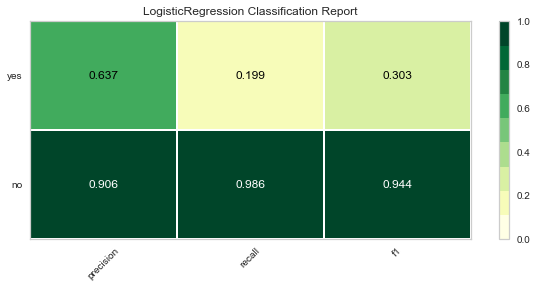

In [78]:
show_classification_rpt(logit)

In [79]:
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

          no       0.91      0.99      0.94      9132
         yes       0.64      0.20      0.30      1165

    accuracy                           0.90     10297
   macro avg       0.77      0.59      0.62     10297
weighted avg       0.88      0.90      0.87     10297



In [80]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred_logit))

Confusion Matrix:
[[9000  132]
 [ 933  232]]


## Decision Tree

In [81]:
tree = DecisionTreeClassifier(random_state=rand_state)

In [82]:
print("Accuracy with Decision Tree", end=': ')
y_pred_tree = fit_predict(tree, X_train, X_test, y_train, y_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print(tree_accuracy)

Accuracy with Decision Tree: 0.8534524618821016


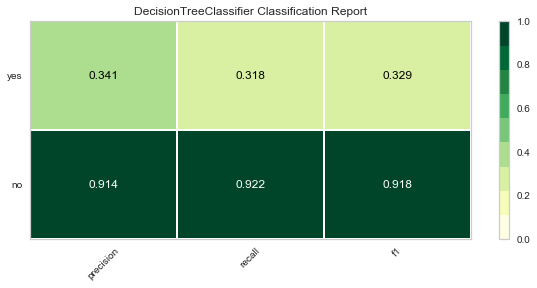

In [83]:
show_classification_rpt(tree)

In [84]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred_tree))

Confusion Matrix:
[[8418  714]
 [ 795  370]]


### Hyper Parameter Tuning

In [85]:
def fit_predict_dt(train, test, y_train, y_test, scaler, max_depth,
               criterion = 'entropy', max_features=1, min_samples_split=4):
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    dt = DecisionTreeClassifier(criterion = criterion, max_depth=max_depth,
                               random_state= 101, max_features=max_features,
                               min_samples_split=min_samples_split)
    dt.fit(train_scaled, y_train)
    y_pred = dt.predict(test_scaled)
    return y_pred

### Max depth parameter tuning

In [86]:
list_max_depth = []

In [87]:
for i in range(1,30):
    print("Accuracy score using max_depth = ", i, end = ':')
    y_pred_tree_hpt = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), i)
    dt_max_depth = accuracy_score(y_test, y_pred_tree_hpt)
    print(dt_max_depth)
    list_max_depth.append(dt_max_depth)
    
max_depth_tuned = list_max_depth.index(max(list_max_depth))+1
print(max_depth_tuned)

Accuracy score using max_depth =  1:0.8868602505584151
Accuracy score using max_depth =  2:0.8868602505584151
Accuracy score using max_depth =  3:0.8864717878993882
Accuracy score using max_depth =  4:0.8869573662231718
Accuracy score using max_depth =  5:0.8887054481887928
Accuracy score using max_depth =  6:0.8870544818879286
Accuracy score using max_depth =  7:0.8868602505584151
Accuracy score using max_depth =  8:0.8872487132174419
Accuracy score using max_depth =  9:0.8877342915412256
Accuracy score using max_depth =  10:0.8874429445469554
Accuracy score using max_depth =  11:0.8872487132174419
Accuracy score using max_depth =  12:0.8877342915412256
Accuracy score using max_depth =  13:0.8853063999223074
Accuracy score using max_depth =  14:0.8881227542002526
Accuracy score using max_depth =  15:0.8860833252403613
Accuracy score using max_depth =  16:0.8868602505584151
Accuracy score using max_depth =  17:0.8821015829853356
Accuracy score using max_depth =  18:0.8834612022919297
A

### Max features tuning

In [88]:
dict_max_features = {}

In [89]:
for i in np.arange(0.1,1.0,0.1):
    print('Accuracy score using max features =', i, end = ":")
    y_pred_max_features = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features=i)
    dt_max_features = accuracy_score(y_test, y_pred_max_features)
    print(dt_max_features)
    dict_max_features[i]=dt_max_features

max_feature_tuned = max(dict_max_features, key=dict_max_features.get)
print(max_feature_tuned)

Accuracy score using max features = 0.1:0.8977372050111683
Accuracy score using max features = 0.2:0.8989997086530057
Accuracy score using max features = 0.30000000000000004:0.9004564436243566
Accuracy score using max features = 0.4:0.8978343206759251
Accuracy score using max features = 0.5:0.8984170146644653
Accuracy score using max features = 0.6:0.898902592988249
Accuracy score using max features = 0.7000000000000001:0.8988054773234923
Accuracy score using max features = 0.8:0.8985141303292221
Accuracy score using max features = 0.9:0.8991939399825192
0.30000000000000004


### Min samples split tuning

In [90]:
dict_min_samples_split = {}

In [91]:
for i in range(2,10):
    print('Accuracy score using min samples split=', i, end=":")
    y_pred_min_split = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features=max_feature_tuned, min_samples_split=i)
    dt_min_sample_split = accuracy_score(y_test, y_pred_min_split)
    print(dt_min_sample_split)
    dict_min_samples_split[i] = dt_min_sample_split
    
min_sample_split_tuned = max(dict_min_samples_split, key=dict_min_samples_split.get)
print(min_sample_split_tuned)

Accuracy score using min samples split= 2:0.9004564436243566
Accuracy score using min samples split= 3:0.9004564436243566
Accuracy score using min samples split= 4:0.9004564436243566
Accuracy score using min samples split= 5:0.89501796639798
Accuracy score using min samples split= 6:0.89501796639798
Accuracy score using min samples split= 7:0.89501796639798
Accuracy score using min samples split= 8:0.8985141303292221
Accuracy score using min samples split= 9:0.8985141303292221
2


### Criterion tuning

In [92]:
dict_index_tuned = {}

In [93]:
for i in ['gini','entropy']:
    print("Accuracy score using criterion: ", i, end = ':')
    y_pred_index_score = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features = max_feature_tuned, min_samples_split=min_sample_split_tuned, criterion= i)
    dt_index_score = accuracy_score(y_test, y_pred_index_score)
    print(dt_index_score)
    dict_index_tuned[i] = dt_index_score

dt_index_tuned = max(dict_index_tuned, key=dict_index_tuned.get)
print(dt_index_tuned)

Accuracy score using criterion:  gini:0.9004564436243566
Accuracy score using criterion:  entropy:0.9004564436243566
gini


### Rerunning decision tree with best parameters

In [94]:
tree_best_pred  =  fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features = max_feature_tuned, min_samples_split=min_sample_split_tuned, criterion= dt_index_tuned)
dt_best_param_score = accuracy_score(y_test, tree_best_pred)
print("Accuracy score for decision tree using best param: ", end = ':')
print(dt_best_param_score)

Accuracy score for decision tree using best param: :0.9004564436243566


In [95]:
tree1 = DecisionTreeClassifier(criterion = dt_index_tuned, max_depth=max_depth_tuned,
                               random_state= rand_state, max_features=max_feature_tuned,
                               min_samples_split=min_sample_split_tuned)

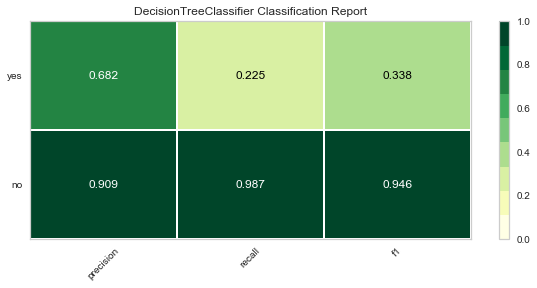

In [96]:
show_classification_rpt(tree1)

In [97]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, tree_best_pred))

Confusion Matrix:
[[9010  122]
 [ 903  262]]


## Random Forest

In [98]:
forest = RandomForestClassifier(criterion='entropy', oob_score=True)

In [99]:
print("Accuracy with Random Forest", end=': ')
rf_pred = fit_predict(forest, X_train, X_test, y_train, y_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(rf_accuracy)

Accuracy with Random Forest: 0.8919102651257648


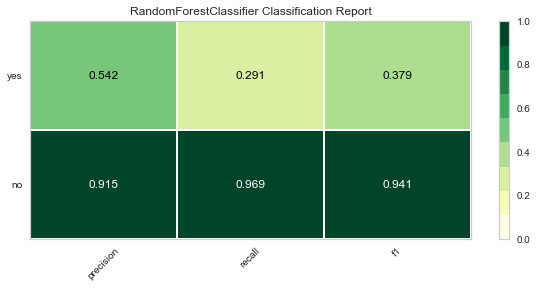

In [100]:
show_classification_rpt(forest)

In [101]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,rf_pred))

Confusion Matrix:
[[8845  287]
 [ 826  339]]


## Accuracy Summary Without Boosting

In [102]:
print("Accuracy with Logistic Regression", end=': ')
print(logit_accuracy)dd
print("Accuracy with Decision Tree", end=': ')
print(tree_accuracy)
print("Accuracy of Decision Tree after Hyper Parameter Tuning: ", end = ':')
print(dt_best_param_score)
print("Accuracy with Random Forest", end=': ')
print(rf_accuracy)

Accuracy with Logistic Regression: 0.8965718170340876
Accuracy with Decision Tree: 0.8534524618821016
Accuracy of Decision Tree after Hyper Parameter Tuning: :0.9004564436243566
Accuracy with Random Forest: 0.8919102651257648


## LGBM

In [103]:
from lightgbm import LGBMClassifier

In [104]:
LGBM = LGBMClassifier(n_jobs=number_of_jobs, num_leaves=31)
LGBM.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [105]:
LGBM_predict = LGBM.predict(X_test)

In [106]:
print("Accuracy with LGBM", end=': ')
lgbm_accuracy = accuracy_score(y_test,LGBM_predict)
print(lgbm_accuracy)

Accuracy with LGBM: 0.9022045255899777


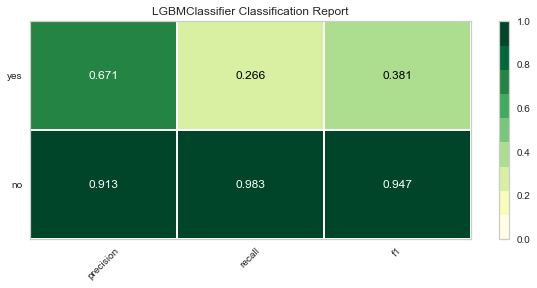

In [107]:
show_classification_rpt(LGBM)

In [108]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, LGBM_predict))

Confusion Matrix:
[[8980  152]
 [ 855  310]]


### LGBM With Grid Search

In [109]:
lgbm_params = {
    'num_leaves': [31,35,40,45,50],
    'learning_rate':[0.03,0.05,0.07],
    'n_estimators': [50,75,100,150]
}

In [110]:
if grid_search_enable == True:
    lgbm_gs = GridSearchCV(LGBM, lgbm_params, cv=cv, n_jobs=number_of_jobs)
    lgbm_gs.fit(X_train, y_train)

In [111]:
if grid_search_enable == True:
    lgbm_best_estimator = lgbm_gs.best_params_['n_estimators']
    lgbm_best_learning_rate = lgbm_gs.best_params_['learning_rate']
    lgbm_best_num_leaves = lgbm_gs.best_params_['num_leaves']
    # lgbm_best_max_depth = lgbm_gs.best_params_['max_depth']
    print(lgbm_gs.best_params_)

{'learning_rate': 0.07, 'n_estimators': 50, 'num_leaves': 35}


### LGBM With Best Parameters

In [112]:
if grid_search_enable == True:
    LGBM_best = LGBMClassifier(n_jobs=number_of_jobs, num_leaves=lgbm_best_num_leaves, 
                               learning_rate=lgbm_best_learning_rate, n_estimators=lgbm_best_estimator,
                              )
    LGBM_best.fit(X_train, y_train)

In [113]:
if grid_search_enable == True:
    LGBM_best_predict = LGBM_best.predict(X_test)
    LGBM_best_accuracy = accuracy_score(y_test,LGBM_best_predict)

In [114]:
if grid_search_enable == True:
    print("Accuracy with LGBM with Hyper Parameter Tuning", end=': ')
    print(LGBM_best_accuracy)

Accuracy with LGBM with Hyper Parameter Tuning: 0.9007477906186268


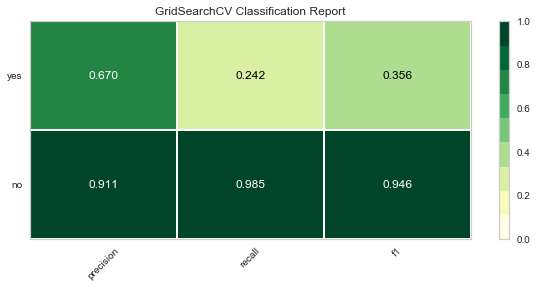

In [115]:
if grid_search_enable == True:
    show_classification_rpt(lgbm_gs)

In [116]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, LGBM_best_predict))

Confusion Matrix:
[[8993  139]
 [ 883  282]]


## Accuracy Summary With LGBM

In [117]:
print("Accuracy with Logistic Regression", end=': ')
print(logit_accuracy)

print("Accuracy with Decision Tree", end=': ')
print(tree_accuracy)
print("Accuracy with Decision Tree after Hyper Parameter Tuning: ", end = ':')
print(dt_best_param_score)

print("Accuracy with Random Forest", end=': ')
print(rf_accuracy)

print("Accuracy with LGBM", end=': ')
print(lgbm_accuracy)
if grid_search_enable == True:
    print("Accuracy with LGBM after Hyper Parameter Tuning", end=': ')
    print(LGBM_best_accuracy)    
    
    

Accuracy with Logistic Regression: 0.8965718170340876
Accuracy with Decision Tree: 0.8534524618821016
Accuracy with Decision Tree after Hyper Parameter Tuning: :0.9004564436243566
Accuracy with Random Forest: 0.8919102651257648
Accuracy with LGBM: 0.9022045255899777
Accuracy with LGBM after Hyper Parameter Tuning: 0.9007477906186268
